In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [112]:
from catboost import CatBoostRegressor, CatBoostClassifier
from catboost import Pool
from sklearn.model_selection import  train_test_split
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    average_precision_score,
    recall_score,
    matthews_corrcoef,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import shap
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

In [113]:
def score_regression_simple(target, predictions,) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)

    metrics = {
        "R2":       round(r2_score(target, predictions),3),
        "MAE":  round(mean_absolute_error(target, predictions),3),
        "MSE":  round(mean_squared_error(target, predictions),3),
        "RMSE":   round((np.sqrt(mean_squared_error(target, predictions))),3),
        "MAPE":        round(mean_absolute_percentage_error(target, predictions),3),
        } 
    return metrics


def score_classifier_simple(target, predictions, threshold=0.5) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)
    response = (predictions > threshold).astype(int)

    metrics = {
        "roc_auc_score":   round((np.sqrt(roc_auc_score(target, predictions))),3),
        "av_precision_score": round((np.sqrt(average_precision_score(target, predictions))),3),
        "accuracy_score":  round(accuracy_score(target, response),3),
        "precision_score":  round(precision_score(target, response),3),
        "recall_score":   round((np.sqrt(recall_score(target, response))),3),
        "f1_score":       round(f1_score(target, response),3),
        "matthews_corrcoef":        round(matthews_corrcoef(target, response),3),
        } 
    return metrics

In [114]:
def calc_min_price_rolling(data, delta_h=24, features=None):
    if features is None:
        features = ['rarity', 'genesis', 'sneaker_type', 'level', 'mint']

    result = np.zeros(len(data))

    for i in range(len(data)):
        #i = 156
        sample = data.iloc[i]
        data_tmp = data.iloc[:i]
        data_tmp = data_tmp[data_tmp['date'] > (sample['date'] - pd.Timedelta(delta_h, unit='h'))]

        for feature in features:
            data_tmp = data_tmp[(data_tmp[feature] == sample[feature])]
        result[i] = data_tmp['price'].min()
    
    return result

# SETUP

In [115]:
BD_NAME = 'export_20220921060002.csv'
BD_FOLDER = './data'
VERSION = 'v2.2.220921'
START_DATE = '2022-09-03'
TETS_DATE = '2022-09-17'

In [116]:
data_quality_expected_range_dict = {
    'sneaker':
        {
        #'is_type': {'genesis': bool},
        'is_in':
            {
            'rarity': ['common', 'uncommon', 'rare'],
            'sneaker_type': ['ranger', 'sprinter', 'hiker', 'coacher'],
            },
        'min_max':
            {
            'level': [0, 30],
            'base_performance': [0, 40],
            'base_fortune': [0, 40],
            'base_joy': [0, 40],
            'base_durability': [0, 40],
            'performance': [0, 500],
            'fortune': [0, 300],
            'joy': [0, 300],
            'durability': [0, 300],
            'mint': [0, 7],
            'buy_count_12H': [0, 500],
            'buy_count_24H': [0, 1000],
            'sell_count_24H': [0, 2000],
            'cancel_count_24H': [0, 1000],
            'token_all_activity_3H': [0, 30],
            'token_sell_activity_6H': [0, 30],
            },
        }
}

# DATA

In [117]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
0,1663739916,35454,51719,sell,0x90e19f892f141e2ca755e7bf07aee5b4f5bb0b7d,NaN,0.86,sneakers,common,sprinter,...,375.0,8250.0,27085,7009,744,3204,6054,10690,88.0,1.490798
1,1663739904,35453,21750,sell,0x0d97edb2df1e0a787f358329aad04c00d83987b6,NaN,0.92,sneakers,common,hiker,...,374.0,8250.0,27085,8172,744,3204,6054,10690,88.0,1.500000
2,1663739778,35233,42053,cancel,0x980f18d18293290117d3b5f1f326ecb754f3b1fe,NaN,NaN,sneakers,uncommon,sprinter,...,376.0,8250.0,27085,7009,745,3204,6055,10691,88.0,1.496933
3,1663739769,35226,47193,cancel,0x980f18d18293290117d3b5f1f326ecb754f3b1fe,NaN,NaN,sneakers,uncommon,hiker,...,376.0,8250.0,27085,8172,745,3204,6056,10691,88.0,1.496933
4,1663739754,35225,51156,cancel,0xf61a9f0c9b3888e6898411c07b02db72c517386f,NaN,NaN,sneakers,uncommon,hiker,...,376.0,8250.0,27085,8172,745,3204,6056,10691,88.0,1.509202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41571,1661029606,13798,24335,sell,0x0d4eafe1ed97f590fde02c21dcf2b0ae6cb106d7,NaN,0.90,sneakers,common,hiker,...,NaN,NaN,15935,4223,257,4546,5226,15935,NaN,NaN
41572,1661029594,13797,27211,sell,0xb83b40609684191abba9184f627a112df5ac0a44,NaN,0.92,sneakers,common,hiker,...,NaN,NaN,15935,4223,257,4546,5226,15935,NaN,NaN
41573,1661029585,13596,32513,buy,0x1041f11e1738c5ea8d3ff3c5a1a314a617313ee1,0x2eeedd73169a17e4f79a6d6bea238f11b05238e4,0.92,box,common,NaN,...,NaN,NaN,904,0,252,1495,1831,2314,NaN,NaN
41574,1661029462,13796,32779,sell,0x668ff3191878ed0f7112031305eccb1d79a865e4,NaN,1.00,sneakers,common,sprinter,...,NaN,NaN,15934,3984,256,4545,5225,15934,NaN,NaN


In [118]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [119]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41576 entries, 0 to 41575
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  30889 non-null  float64
 1   time_ownership             30889 non-null  float64
 2   wallet_box_mint            30889 non-null  float64
 3   wallet_sneaker_mint        30889 non-null  float64
 4   time_level_up              28147 non-null  float64
 5   time_level_up_for_mint     30889 non-null  float64
 6   base_mint_price_amt        30889 non-null  float64
 7   base_mint_price_azy        30889 non-null  float64
 8   base_mint_price_bnb        20866 non-null  float64
dtypes: float64(9)
memory usage: 2.9 MB


In [120]:
data.genesis

0        False
1         True
2        False
3        False
4        False
         ...  
41571     True
41572    False
41573    False
41574    False
41575     True
Name: genesis, Length: 41576, dtype: bool

In [121]:
data = data[(data.item_type == 'sneakers') & (data.event == 'buy')].copy()
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
15,1663739253,35443,49180,buy,0x90e19f892f141e2ca755e7bf07aee5b4f5bb0b7d,0x7e4e20561fcec9a545d3faaf64851a5e78494cb7,0.78,sneakers,common,ranger,...,377.0,8250.0,27084,7505,748,3205,6057,10692,87.0,1.521472
17,1663739163,35445,51137,buy,0x60f16840bf3fb04074333b836d22822002b45704,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0.80,sneakers,common,ranger,...,379.0,8249.0,27084,7505,749,3207,6057,10692,87.0,1.524390
21,1663739073,35340,29347,buy,0x674426edd6985de6e3b860902e6765c51a69b33e,0x60f16840bf3fb04074333b836d22822002b45704,0.80,sneakers,common,hiker,...,378.0,8250.0,27084,8172,752,3208,6057,10692,87.0,1.521472
24,1663738986,35437,21901,buy,0xec6673229743549642fe6dd7a3117be5d8b377d4,0xad728e59e1b735398f3f2b7a59b9d5a1a651f2db,0.79,sneakers,common,hiker,...,378.0,8250.0,27084,8172,754,3208,6057,10692,87.0,1.496970
35,1663738833,35432,25523,buy,0x34bf260019ddef3574c1e886f3b6e3895f277b84,0x312d5b8c02b1e4a1c414fe4dde3fa2fe390edaf9,0.97,sneakers,common,hiker,...,383.0,8249.0,27084,8172,756,3209,6057,10693,87.0,1.506024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41513,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,15972,3657,275,4576,5258,15972,NaN,NaN
41536,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,15954,4077,261,4559,5240,15954,NaN,NaN
41550,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,15942,4226,253,4552,5230,15942,NaN,NaN
41555,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,15938,4073,253,4548,5228,15938,NaN,NaN


# data_quality

In [122]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    for element in data[feature].unique():
        if element not in dq[feature]:
            print(f'{feature} not in data_quality_expected_range_dict. get {element}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    if data[feature].min() < dq[feature][0]:
        print(f'{feature} less then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

    if data[feature].max() > dq[feature][1]:
        print(f'{feature} more then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

In [123]:
data['mint'].isna().sum()

0

In [124]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8326 entries, 15 to 41569
Data columns (total 75 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        8326 non-null   int64  
 1   mrk_id                                           8326 non-null   int64  
 2   token_id                                         8326 non-null   int64  
 3   event                                            8326 non-null   object 
 4   wallet_from                                      8326 non-null   object 
 5   wallet_to                                        8326 non-null   object 
 6   price                                            8326 non-null   float64
 7   item_type                                        8326 non-null   object 
 8   rarity                                           8326 non-null   object 
 9   sneaker_type                

In [125]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8326 entries, 15 to 41569
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  8326 non-null   float64
 1   time_ownership             8326 non-null   float64
 2   wallet_box_mint            8326 non-null   float64
 3   wallet_sneaker_mint        8326 non-null   float64
 4   time_level_up              8326 non-null   float64
 5   time_level_up_for_mint     8326 non-null   float64
 6   base_mint_price_amt        8326 non-null   float64
 7   base_mint_price_azy        8326 non-null   float64
 8   base_mint_price_bnb        5936 non-null   float64
dtypes: float64(9)
memory usage: 650.5 KB


In [126]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
15,1.657801e+09,282.0,6.0,4.0,900.0,1800.0,300.0,200.0,0.661364
17,1.657800e+09,376168.0,9.0,9.0,0.0,1800.0,300.0,200.0,0.661364
21,1.657839e+09,10155.0,5.0,5.0,1260.0,1800.0,300.0,200.0,0.661364
24,1.657810e+09,306.0,6.0,6.0,900.0,1800.0,300.0,200.0,0.661364
35,1.657811e+09,522.0,5.0,5.0,900.0,1800.0,300.0,200.0,0.660887
...,...,...,...,...,...,...,...,...,...
41513,1.657803e+09,18915.0,5.0,0.0,900.0,1800.0,300.0,200.0,NaN
41536,1.657800e+09,5178.0,6.0,10.0,900.0,1800.0,300.0,200.0,NaN
41550,1.657800e+09,446391.0,5.0,7.0,900.0,1800.0,300.0,200.0,NaN
41555,1.659970e+09,1062034.0,0.0,1.0,2700.0,1800.0,300.0,200.0,NaN


In [127]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [128]:
#int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint']
#float_columns = ['performance', 'fortune', 'joy', 'durability', 'price']
#cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [129]:
#for columns in int_columns:
#    data[columns] = data[columns].astype('int')

# for columns in float_columns:
#     data[columns] = data[columns].astype('float')

#for columns in cat_columns:
#    data[columns] = data[columns].astype('category')

In [130]:
#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

In [131]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8326 entries, 15 to 41569
Data columns (total 75 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        8326 non-null   int64  
 1   mrk_id                                           8326 non-null   int64  
 2   token_id                                         8326 non-null   int64  
 3   event                                            8326 non-null   object 
 4   wallet_from                                      8326 non-null   object 
 5   wallet_to                                        8326 non-null   object 
 6   price                                            8326 non-null   float64
 7   item_type                                        8326 non-null   object 
 8   rarity                                           8326 non-null   object 
 9   sneaker_type                

In [132]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
15,1663739253,35443,49180,buy,0x90e19f892f141e2ca755e7bf07aee5b4f5bb0b7d,0x7e4e20561fcec9a545d3faaf64851a5e78494cb7,0.78,sneakers,common,ranger,...,377.0,8250.0,27084,7505,748,3205,6057,10692,87.0,1.521472
17,1663739163,35445,51137,buy,0x60f16840bf3fb04074333b836d22822002b45704,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0.80,sneakers,common,ranger,...,379.0,8249.0,27084,7505,749,3207,6057,10692,87.0,1.524390
21,1663739073,35340,29347,buy,0x674426edd6985de6e3b860902e6765c51a69b33e,0x60f16840bf3fb04074333b836d22822002b45704,0.80,sneakers,common,hiker,...,378.0,8250.0,27084,8172,752,3208,6057,10692,87.0,1.521472
24,1663738986,35437,21901,buy,0xec6673229743549642fe6dd7a3117be5d8b377d4,0xad728e59e1b735398f3f2b7a59b9d5a1a651f2db,0.79,sneakers,common,hiker,...,378.0,8250.0,27084,8172,754,3208,6057,10692,87.0,1.496970
35,1663738833,35432,25523,buy,0x34bf260019ddef3574c1e886f3b6e3895f277b84,0x312d5b8c02b1e4a1c414fe4dde3fa2fe390edaf9,0.97,sneakers,common,hiker,...,383.0,8249.0,27084,8172,756,3209,6057,10693,87.0,1.506024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41513,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,15972,3657,275,4576,5258,15972,NaN,NaN
41536,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,15954,4077,261,4559,5240,15954,NaN,NaN
41550,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,15942,4226,253,4552,5230,15942,NaN,NaN
41555,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,15938,4073,253,4548,5228,15938,NaN,NaN


In [133]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

In [134]:
data[data.duplicated(['token_id', 'item_type', 'rarity', 'sneaker_type', 'level', 'mint',])]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis,date
41080,1661076949,14027,23846,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0x7bdf18948f2b640ba7fea97875849038bd43da2c,0.73,sneakers,common,sprinter,...,NaN,16182,4070,391,4746,5443,16182,NaN,NaN,2022-08-21 10:15:49
41029,1661079343,14070,20408,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0x7dd69ca014565e2c9e1b47beabf57a4469d51fe1,0.73,sneakers,common,sprinter,...,NaN,16191,4072,387,4748,5448,16191,NaN,NaN,2022-08-21 10:55:43
40826,1661087557,14094,26385,buy,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,0x06333746416b07371d84d1f862a352ec7ca1ab10,1.16,sneakers,common,hiker,...,NaN,16227,4332,384,4770,5469,16227,NaN,NaN,2022-08-21 13:12:37
40631,1661095945,14208,16352,buy,0xec04f1a68a3618028f3431ccf570508d95d34dce,0x3ae4020278e724bec4d24135bf9d42b6879a648f,0.69,sneakers,common,sprinter,...,NaN,16258,4083,380,4791,5492,16258,NaN,NaN,2022-08-21 15:32:25
39900,1661155769,14662,31425,buy,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0xf1a560df54f04b45e756d1cb36241fec633134a2,0.70,sneakers,common,sprinter,...,NaN,16415,4126,251,4875,5592,16415,NaN,NaN,2022-08-22 08:09:29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,1663710204,35012,32244,buy,0xae9dbe3feb9fd03945ed79f79142e8787fe47907,0x560557de98164cff5fdd4b16c0145186c21cc064,1.09,sneakers,common,hiker,...,8231.0,27019,8151,769,3183,6041,10667,83.0,1.154867,2022-09-20 21:43:24
551,1663712827,34989,19545,buy,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0x8780c32bad8c7c3ff91fe482802076f2444fb8dd,1.24,sneakers,common,ranger,...,8234.0,27029,7487,757,3188,6043,10672,85.0,1.175115,2022-09-20 22:27:07
350,1663720900,34997,19542,buy,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0xe76a65c96066ce50c943ac0f6e1445d4f4abb2fc,1.79,sneakers,common,coacher,...,8238.0,27055,4398,759,3203,6052,10687,86.0,1.275862,2022-09-21 00:41:40
249,1663727061,35316,42762,buy,0xf61a9f0c9b3888e6898411c07b02db72c517386f,0x6fe484d6d73268b9a460070e660ca0c7184584ba,0.78,sneakers,common,sprinter,...,8240.0,27062,7001,755,3203,6052,10690,85.0,1.317949,2022-09-21 02:24:21


In [135]:
#len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

In [136]:
#train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()

# ML

## FE

In [137]:
#data['min_price_by_rarity_genesis_type_level_mint_24H_nan'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].isna()
#data['min_price_by_rarity_genesis_type_24H_nan'] = data['min_price_by_rarity_genesis_type_24H'].isna()

#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']

In [138]:
data['token_sell_activity_6H'].max()

11

In [139]:
data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(np.nan)
data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(np.nan)

In [140]:
# Перекуп датасет

dupl_df = data[data.duplicated(['token_id', 'item_type', 'rarity', 'sneaker_type', 'level', 'mint',], keep=False)]

In [141]:
data[data['token_id'] == 34874]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis,date,sum_activity_24H,sells_activity_24H
26416,1662138884,21406,34874,buy,0x92ede55a13c314bc7ca513734240d5d751b73008,0xa9343304ac2e9e45c0470e1ece4ca37c9774ce51,1.07,sneakers,common,coacher,...,3942,323,1584,4052,13161,NaN,NaN,2022-09-02 17:14:44,1654,1.869180
22178,1662430561,23510,34874,buy,0xa9343304ac2e9e45c0470e1ece4ca37c9774ce51,0x3273af210822c44afd7254510e612e4dbb1040a7,0.97,sneakers,common,coacher,...,4018,287,2007,3803,9987,NaN,NaN,2022-09-06 02:16:01,1079,2.341772


In [142]:
len(dupl_df)

1969

In [143]:
count_list = []
final_df = pd.DataFrame()

for token_id in dupl_df['token_id'].unique():
    data_tmp = dupl_df[dupl_df['token_id'] == token_id]
    #if data_tmp.iloc[0]['wallet_to'] == data_tmp.iloc[1]['wallet_from']:
    #print(len(data_tmp))
    i=0
    #for i in range(len(data_tmp)-1):
        #print(i)
    sample = data_tmp.iloc[i].copy()
    sample['sell_wallet_from'] = data_tmp.iloc[i+1]['wallet_from']
    sample['sell_price'] = data_tmp.iloc[i+1]['price']
    sample['sell_data'] = data_tmp.iloc[i+1]['date']
    sample['profit'] = (data_tmp.iloc[i+1]['price'] - ((data_tmp.iloc[i+1]['price']/100) * 5)) - data_tmp.iloc[i]['price']
    final_df = pd.concat([final_df, sample], ignore_index=True, sort=False, axis=1)
    
    #break

In [144]:
final_df = final_df.T
final_df

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis,date,sum_activity_24H,sells_activity_24H,sell_wallet_from,sell_price,sell_data,profit
0,1661065858,13953,31752,buy,0x8109ddb2277068a597cc9511e94f288b4f72e36c,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0.76,sneakers,common,sprinter,...,16155,NaN,NaN,2022-08-21 07:10:58,911,4.683168,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0.9,2022-09-02 20:03:07,0.095
1,1661069971,13988,23846,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.5,sneakers,common,sprinter,...,16168,NaN,NaN,2022-08-21 08:19:31,908,4.256881,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:15:49,0.1935
2,1661070010,13991,20408,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.5,sneakers,common,sprinter,...,16169,NaN,NaN,2022-08-21 08:20:10,910,4.227273,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:55:43,0.1935
3,1661079088,14089,26385,buy,0x25ad8afeb7b5c119fdbabb2ec99f84a611caea2a,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,0.8,sneakers,common,hiker,...,16191,NaN,NaN,2022-08-21 10:51:28,978,4.469027,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,1.16,2022-08-21 13:12:37,0.302
4,1661082994,14081,26390,buy,0x627afb1341cb1ae3cb3546424709dba42d88bde9,0xd96fcc51a852767af7a599a5bdf2daf0f162627b,0.72,sneakers,common,sprinter,...,16204,NaN,NaN,2022-08-21 11:56:34,998,4.557522,0xd96fcc51a852767af7a599a5bdf2daf0f162627b,0.7,2022-08-29 16:25:54,-0.055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,1663681748,34593,51423,buy,0xa0dd87348f7788f64755de5dc9239173bdfd3ce6,0x3273af210822c44afd7254510e612e4dbb1040a7,0.88,sneakers,common,ranger,...,10316,89.0,0.948113,2022-09-20 13:49:08,1509,2.281501,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,1.08,2022-09-20 15:18:28,0.146
898,1663700032,34890,19545,buy,0xc6571c2fb66825f13b7751b1c334810d397618eb,0x3273af210822c44afd7254510e612e4dbb1040a7,0.81,sneakers,common,ranger,...,10655,90.0,1.108108,2022-09-20 18:53:52,1433,2.567976,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,1.24,2022-09-20 22:27:07,0.368
899,1663700143,34894,19542,buy,0xc6571c2fb66825f13b7751b1c334810d397618eb,0x3273af210822c44afd7254510e612e4dbb1040a7,1.0,sneakers,common,coacher,...,10655,89.0,1.108108,2022-09-20 18:55:43,1434,2.557229,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,1.79,2022-09-21 00:41:40,0.7005
900,1663707592,35071,29439,buy,0x262346361e0f004e0c20a58b08ba883d18a7caf7,0x3273af210822c44afd7254510e612e4dbb1040a7,0.78,sneakers,common,coacher,...,10656,90.0,1.165919,2022-09-20 20:59:52,1499,3.153584,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.97,2022-09-20 21:22:56,0.1415


In [145]:
final_df.profit.median()

0.030000000000000027

In [146]:
final_df.profit.sum()

6.654224999999997

In [147]:
len(final_df.groupby('wallet_to')['profit'].sum())

286

In [148]:
(final_df.groupby('wallet_to')['profit'].sum().sort_values() > 0).sum()

145

In [149]:
(final_df.groupby('wallet_to')['profit'].sum().sort_values() > 1).sum()

13

In [150]:
final_df.groupby('wallet_to')['profit'].sum().sort_values()

wallet_to
0xe58ea7792930a4b52b4b4701b88ec709b205c54d   -8.459425
0xee17c73127c83d876758f8750fd4c81710673d2b     -7.3965
0x4a37b679463b90481547956da5b0432d45c867a5      -6.836
0x5eddc3624cf47c37eb7f056ab23150e502341d0a     -6.8065
0xda9f0564c09479c9c54e653b05c47bfe663952a6        -5.2
                                                ...   
0xa6ab391afaad74f1398641734d72018163d16220      2.1825
0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba      4.2005
0xff06dbe17724093ce542247b28beef42dedb9f4b      4.3415
0xf3df1c64cb2e66400ef968caabfbe665457d25d4       6.156
0x3273af210822c44afd7254510e612e4dbb1040a7       16.95
Name: profit, Length: 286, dtype: object

In [151]:
(final_df.wallet_to.value_counts() > 1).sum()

115

In [152]:
# фильтр по количеству сделок
len(final_df.wallet_to.value_counts()[final_df.wallet_to.value_counts() > 10])

8

In [153]:
select_wallets = final_df.wallet_to.value_counts()[final_df.wallet_to.value_counts() > 10].index
final_df = final_df[final_df.wallet_to.isin(select_wallets)].copy()

In [154]:
len(final_df)

316

In [155]:
# фильтр только прибыльных торгошей
final_df.groupby('wallet_to')['profit'].sum()[final_df.groupby('wallet_to')['profit'].sum() > 2].sort_values()

wallet_to
0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba    4.2005
0xff06dbe17724093ce542247b28beef42dedb9f4b    4.3415
0x3273af210822c44afd7254510e612e4dbb1040a7     16.95
Name: profit, dtype: object

In [156]:
select_wallets = final_df.groupby('wallet_to')['profit'].sum()[final_df.groupby('wallet_to')['profit'].sum() > 2].index
final_df = final_df[final_df.wallet_to.isin(select_wallets)].copy()
len(final_df)

200

In [157]:
final_df['sell_time'] = ((final_df['sell_data'] - final_df['date']) / np.timedelta64(1,'h')).astype(int)

In [158]:
final_df['sell_time']

52      51
55      57
76      32
77      11
79     136
      ... 
885     14
897      1
898      3
899      5
900      0
Name: sell_time, Length: 200, dtype: int64

In [159]:
final_df['target'] = final_df['profit']

In [160]:
final_df['target'].max()

0.8815

In [161]:
final_df['target'].min()

-2.6075000000000004

# Model

In [162]:
data = final_df.copy()

In [163]:
int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint', 'buy_count_12H',
    'buy_count_24H','sum_activity_24H','token_all_activity_3H',
    'token_sell_activity_6H','time_level_up']
float_columns = ['base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability', 'price', 'min_price_all_24H',
    'sells_activity_24H',
    'min_price_by_rarity_genesis_type_level_mint_24H',
    'min_price_by_rarity_genesis_type_level_mint_48H',
    'min_price_by_rarity_genesis_type_level_mint_72H',
    'min_price_by_rarity_genesis_type_24H','profit', 
    'base_mint_price_amt',
    'base_mint_price_azy', 
    'base_mint_price_bnb',
    'price_bnb', 
    'price_azy', 
    'price_amt',
    'target']
cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [164]:
for columns in int_columns:
    data[columns] = data[columns].astype('int')

for columns in float_columns:
    data[columns] = data[columns].astype('float')

for columns in cat_columns:
    data[columns] = data[columns].astype('category')

In [165]:
data['genesis'] = data['genesis'].astype('bool')

In [166]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)
predict_price = model.predict(data[model.feature_names_])
predict_price = np.round(predict_price, 3)
data['predict'] = predict_price
#predict_price

In [167]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(data[model.feature_names_])
predict_price = np.round(predict_price, 2)
data['predict_base'] = predict_price

In [168]:
data['profit_by_predict_model'] = np.round((data['price'] - ((data['predict']/100) * 5)) - data['price'], 3)

In [169]:
data['profit_by_predict_base_model'] = np.round((data['price'] - ((data['predict_base']/100) * 5)) - data['price'], 3)

In [170]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,sum_activity_24H,sells_activity_24H,sell_wallet_from,sell_price,sell_data,profit,sell_time,target,profit_by_predict_model,profit_by_predict_base_model
52,1661330758,15771,14732,buy,0x50246a336021f120dc42a694d574f6fa593c130f,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.70,sneakers,common,sprinter,...,938,3.081633,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.82,2022-08-26 12:24:47,0.0790,51,0.0790,-0.045,-0.046
55,1661342057,15841,24003,buy,0xbf4296b6e85d8aa032c091edf006bf5fe3f3b5b3,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.68,sneakers,common,sprinter,...,917,3.020000,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.85,2022-08-26 21:45:51,0.1275,57,0.1275,-0.046,-0.046
76,1661438542,16446,15848,buy,0x8ddaeb2ecd2a4fc4e29e82067cd2d1d84649e544,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.67,sneakers,common,sprinter,...,895,3.089041,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.79,2022-08-26 23:28:36,0.0805,32,0.0805,-0.040,-0.042
77,1661438812,16448,36542,buy,0xa874128dc7703a2909ad89591ac684cf228f4ea1,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.79,sneakers,common,ranger,...,893,3.075342,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.89,2022-08-26 01:56:14,0.0555,11,0.0555,-0.049,-0.051
79,1661440348,16461,22239,buy,0x878cda24c1433184a8ea963fb1638c9fd35bfa8f,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.75,sneakers,common,hiker,...,876,2.952381,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.89,2022-08-31 07:52:29,0.0955,136,0.0955,-0.040,-0.042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,1663615968,34015,25352,buy,0x8aa37a4036f03ee2fc7f142f2ca7072411913af5,0x3273af210822c44afd7254510e612e4dbb1040a7,0.80,sneakers,common,coacher,...,1576,2.437326,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,1.09,2022-09-20 10:28:24,0.2355,14,0.2355,-0.046,-0.048
897,1663681748,34593,51423,buy,0xa0dd87348f7788f64755de5dc9239173bdfd3ce6,0x3273af210822c44afd7254510e612e4dbb1040a7,0.88,sneakers,common,ranger,...,1509,2.281501,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,1.08,2022-09-20 15:18:28,0.1460,1,0.1460,-0.049,-0.048
898,1663700032,34890,19545,buy,0xc6571c2fb66825f13b7751b1c334810d397618eb,0x3273af210822c44afd7254510e612e4dbb1040a7,0.81,sneakers,common,ranger,...,1433,2.567976,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,1.24,2022-09-20 22:27:07,0.3680,3,0.3680,-0.050,-0.053
899,1663700143,34894,19542,buy,0xc6571c2fb66825f13b7751b1c334810d397618eb,0x3273af210822c44afd7254510e612e4dbb1040a7,1.00,sneakers,common,coacher,...,1434,2.557229,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,1.79,2022-09-21 00:41:40,0.7005,5,0.7005,-0.068,-0.072


In [171]:
len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

131

In [172]:
data = data[(data.date >= START_DATE)].copy()
train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()
test_data = data[(data.date > TETS_DATE)].copy()

In [173]:
train_data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [174]:
train_data[['price_bnb', 'price_azy', 'price_amt', 'wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb', 'date']]

,price_bnb,price_azy,price_amt,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb,date
460,276.798229,0.111966,0.519497,1659203035.0,1125777.0,2.0,3.0,60,1800.0,300.0,200.0,0.643943,2022-09-03 07:06:55
461,276.883697,0.111953,0.516913,1660744494.0,150.0,0.0,0.0,900,1800.0,300.0,200.0,0.640935,2022-09-03 07:33:34
464,276.171518,0.111510,0.521967,1659438695.0,216.0,3.0,3.0,900,1800.0,300.0,200.0,0.647758,2022-09-03 08:35:22
472,277.109304,0.099167,0.552721,1658162819.0,519011.0,7.0,10.0,900,1800.0,300.0,200.0,0.669951,2022-09-03 13:00:04
473,277.268066,0.100288,0.550715,1659438695.0,273.0,3.0,3.0,900,1800.0,300.0,200.0,0.668205,2022-09-03 13:18:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...
823,273.383201,0.082479,0.556509,1662710482.0,20965.0,1.0,1.0,2160,1800.0,300.0,200.0,0.671030,2022-09-16 00:50:12
827,275.461441,0.080994,0.552836,1662729948.0,89881.0,0.0,0.0,3300,1800.0,300.0,200.0,0.660889,2022-09-16 09:35:34
830,277.046354,0.080868,0.553509,1660834452.0,2072555.0,3.0,3.0,3960,1800.0,300.0,200.0,0.657747,2022-09-16 11:55:15
833,273.582605,0.083529,0.562362,1663069583.0,181191.0,0.0,0.0,2700,1800.0,300.0,200.0,0.677727,2022-09-16 19:13:28


In [175]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131 entries, 460 to 835
Data columns (total 86 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   timestamp                                        131 non-null    int64         
 1   mrk_id                                           131 non-null    int64         
 2   token_id                                         131 non-null    int64         
 3   event                                            131 non-null    object        
 4   wallet_from                                      131 non-null    object        
 5   wallet_to                                        131 non-null    object        
 6   price                                            131 non-null    float64       
 7   item_type                                        131 non-null    category      
 8   rarity                                

In [176]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    #'wallet_from_buy_count',
    #'wallet_from_all_count',
    'level',
    # 'base_performance',
    # 'base_fortune',
    # 'base_joy',
    # 'base_durability',
    # 'performance',
    # 'fortune',
    # 'joy',
    # 'durability',
    'mint',
    #'buy_count_12H',
    #'buy_count_24H',
    #'min_price_all_24H',
    #'sum_activity_24H',
    #'sells_activity_24H',
    #'min_price_by_rarity_genesis_type_level_mint_24H',
    'min_price_by_rarity_genesis_type_level_mint_48H',
    #'min_price_by_rarity_genesis_type_level_mint_72H',
    #'min_price_by_rarity_genesis_type_24H',
    #'min_price_by_rarity_genesis_type_48H',
    #'min_price_by_rarity_genesis_type_72H',
    #'token_all_activity_3H',
    #'token_sell_activity_6H',
    'price',
    #'sell_price',
    #'profit',
    #'time_level_up', 
    #'time_level_up_for_mint', 
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    #'base_mint_price_bnb',
    #'price_bnb', 
    #'price_azy', 
    #'price_amt',
    #'predict',
    #'predict_base',
    'profit_by_predict_model',
    'profit_by_predict_base_model',
    ]
cat_features = [0, 1, 2,]

In [177]:
X = data[features].copy().reset_index(drop=True)
y = data.target.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.target.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.target.copy().reset_index(drop=True)

In [178]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    model = CatBoostRegressor(
        depth=3,
        #learning_rate=0.01,
        #iterations=1000,
        loss_function='MAPE',
        random_seed=42
        )

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

30it [00:08,  3.46it/s]


In [179]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,-0.520,2.1853
MAE,0.089,0.0661
MSE,0.086,0.2021
RMSE,0.190,0.2279
MAPE,0.825,0.4935


In [180]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,-0.520,2.1853
MAE,0.089,0.0661
MSE,0.086,0.2021
RMSE,0.190,0.2279
MAPE,0.825,0.4935


In [181]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': -0.14, 'MAE': 0.089, 'MSE': 0.087, 'RMSE': 0.296, 'MAPE': 0.826}

In [182]:
# Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

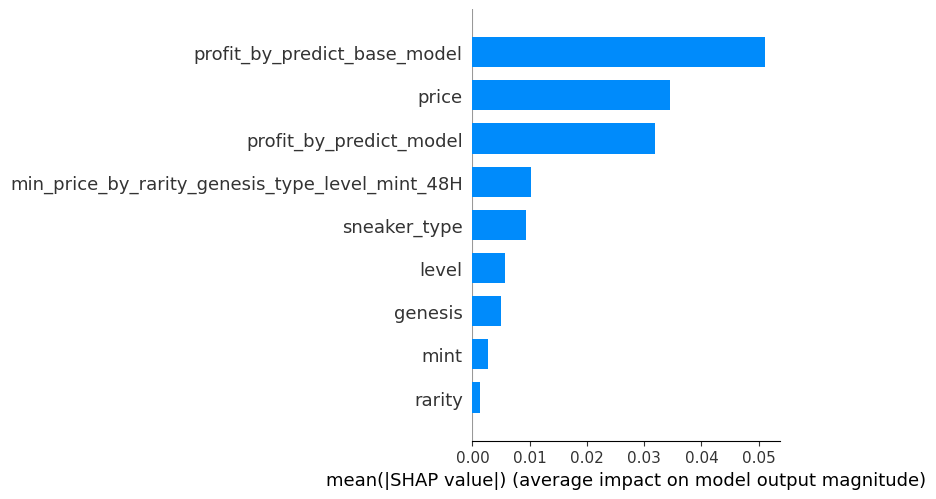

In [183]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## TEST

In [184]:
model = CatBoostRegressor(
    depth=3,
    #learning_rate=0.01,
    #iterations=1000,
    loss_function='MAPE',
    random_seed=42
    )

# Fit model 
model.fit(X_train, y_train, cat_features=cat_features,)
#model.save_model(f'./models/sneaker_model_{VERSION}.model')

0:	learn: 0.0956718	total: 528us	remaining: 528ms
1:	learn: 0.0950445	total: 1.05ms	remaining: 527ms
2:	learn: 0.0940229	total: 1.59ms	remaining: 530ms
3:	learn: 0.0933492	total: 2.15ms	remaining: 534ms
4:	learn: 0.0924352	total: 2.69ms	remaining: 535ms
5:	learn: 0.0915420	total: 3.16ms	remaining: 524ms
6:	learn: 0.0907368	total: 3.6ms	remaining: 511ms
7:	learn: 0.0901295	total: 4.09ms	remaining: 508ms
8:	learn: 0.0892209	total: 4.54ms	remaining: 500ms
9:	learn: 0.0884304	total: 5.01ms	remaining: 496ms
10:	learn: 0.0878550	total: 5.5ms	remaining: 494ms
11:	learn: 0.0874853	total: 5.94ms	remaining: 489ms
12:	learn: 0.0871095	total: 6.42ms	remaining: 488ms
13:	learn: 0.0866770	total: 6.94ms	remaining: 489ms
14:	learn: 0.0862192	total: 7.49ms	remaining: 492ms
15:	learn: 0.0859571	total: 7.93ms	remaining: 488ms
16:	learn: 0.0853931	total: 8.32ms	remaining: 481ms
17:	learn: 0.0852257	total: 8.74ms	remaining: 477ms
18:	learn: 0.0850456	total: 8.98ms	remaining: 464ms
19:	learn: 0.0846795	tota

In [185]:
pred = model.predict(X_test)
pred = np.round(pred, 3)

score = score_regression_simple(y_test, pred,)
score

{'R2': 0.333, 'MAE': 0.14, 'MSE': 0.026, 'RMSE': 0.161, 'MAPE': 0.418}

In [186]:
submission = pd.DataFrame()
submission['profit'] = test_data.profit.copy().reset_index(drop=True)
submission['pred'] = pred

In [187]:
submission.profit.sum()

2.052

In [188]:
submission

,profit,pred
0,0.4605,0.210
1,0.2355,0.131
2,0.1460,0.111
3,0.3680,0.151
4,0.7005,0.528
5,0.1415,0.204


In [189]:
submission[submission['pred'] > 0.05].profit.sum()

2.052

In [190]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

{'R2': 0.335, 'MAE': 0.14, 'MSE': 0.026, 'RMSE': 0.161, 'MAPE': 0.415}

## Fit full Model

In [191]:
X = data[features].copy().reset_index(drop=True)
y = data.target.copy().reset_index(drop=True)

model = CatBoostRegressor(
    depth=3,
    #learning_rate=0.01,
    #iterations=1000,
    loss_function='MAPE',
    random_seed=42
    )

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_profit_model_{VERSION}.model')

0:	learn: 0.1019744	total: 616us	remaining: 616ms
1:	learn: 0.1008289	total: 1.32ms	remaining: 661ms
2:	learn: 0.0995630	total: 1.73ms	remaining: 573ms
3:	learn: 0.0988949	total: 2.13ms	remaining: 531ms
4:	learn: 0.0980112	total: 2.47ms	remaining: 492ms
5:	learn: 0.0972467	total: 2.84ms	remaining: 471ms
6:	learn: 0.0966279	total: 3.21ms	remaining: 456ms
7:	learn: 0.0960459	total: 3.51ms	remaining: 436ms
8:	learn: 0.0954608	total: 3.92ms	remaining: 432ms
9:	learn: 0.0946120	total: 4.32ms	remaining: 427ms
10:	learn: 0.0939711	total: 4.74ms	remaining: 427ms
11:	learn: 0.0934419	total: 5.19ms	remaining: 427ms
12:	learn: 0.0930133	total: 5.68ms	remaining: 431ms
13:	learn: 0.0927319	total: 6.12ms	remaining: 431ms
14:	learn: 0.0921562	total: 6.5ms	remaining: 427ms
15:	learn: 0.0917085	total: 6.92ms	remaining: 426ms
16:	learn: 0.0914779	total: 7.32ms	remaining: 423ms
17:	learn: 0.0909733	total: 7.66ms	remaining: 418ms
18:	learn: 0.0906511	total: 8.02ms	remaining: 414ms
19:	learn: 0.0900361	tot

In [192]:
y

0      0.0770
1      0.0455
2      0.1740
3      0.3305
4      0.0685
        ...  
132    0.2355
133    0.1460
134    0.3680
135    0.7005
136    0.1415
Name: target, Length: 137, dtype: float64

### Test

In [193]:
i=102

In [194]:
sneaker_dict = {}

features = data.columns

for feature in features:
    sneaker_dict[feature] = data.iloc[i][feature]

sneaker_dict['sum_activity_24H'] = sneaker_dict['buy_count_24H'] + sneaker_dict['sell_count_24H'] + sneaker_dict['cancel_count_24H']
sneaker_dict['sells_activity_24H'] = sneaker_dict['sell_count_24H'] / sneaker_dict['buy_count_24H']

sneaker_dict

{'timestamp': 1663062245,
 'mrk_id': 28652,
 'token_id': 29213,
 'event': 'buy',
 'wallet_from': '0x05a1a11f5f0bfcf97d9813f07f813e92547032cb',
 'wallet_to': '0x3273af210822c44afd7254510e612e4dbb1040a7',
 'price': 0.75,
 'item_type': 'sneakers',
 'rarity': 'common',
 'sneaker_type': 'ranger',
 'level': 5,
 'base_performance': 2.0,
 'base_fortune': 4.6,
 'base_joy': 3.6,
 'base_durability': 6.3,
 'performance': 18.0,
 'fortune': 7.1,
 'joy': 5.6,
 'durability': 9.3,
 'mint': 2,
 'parent1': 10413.0,
 'parent2': nan,
 'genesis': True,
 'parent1_sneaker_type': nan,
 'parent2_sneaker_type': nan,
 'price_bnb': 293.08693043,
 'price_azy': 0.08820386,
 'price_amt': 0.54663499,
 'wallet_from_buy_count': 0,
 'wallet_from_all_count': 1,
 'token_all_activity_3H': 1,
 'token_sell_activity_6H': 1,
 'buy_count_12H': 61,
 'buy_count_24H': 288,
 'buy_count_48H': 524,
 'sell_count_12H': 223,
 'sell_count_24H': 680,
 'sell_count_48H': 1223,
 'cancel_count_12H': 115,
 'cancel_count_24H': 421,
 'cancel_coun

In [195]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] not in dq[feature]:
        print(f'{feature} not in data_quality_expected_range_dict. get {sneaker_dict[feature]}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] < dq[feature][0]:
        print(f'{feature} less then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][0]}')

    if sneaker_dict[feature] > dq[feature][1]:
        print(f'{feature} more then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][1]}')

In [196]:
pd.Series(sneaker_dict)[model.feature_names_]

rarity                                             common
sneaker_type                                       ranger
genesis                                              True
level                                                   5
mint                                                    2
min_price_by_rarity_genesis_type_level_mint_48H      0.69
price                                                0.75
profit_by_predict_model                             -0.04
profit_by_predict_base_model                       -0.042
dtype: object

In [197]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_profit_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

sample = pd.Series(sneaker_dict)
predict_price = model.predict(sample[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

0.046

In [198]:
data.iloc[i]['profit']

0.019500000000000073

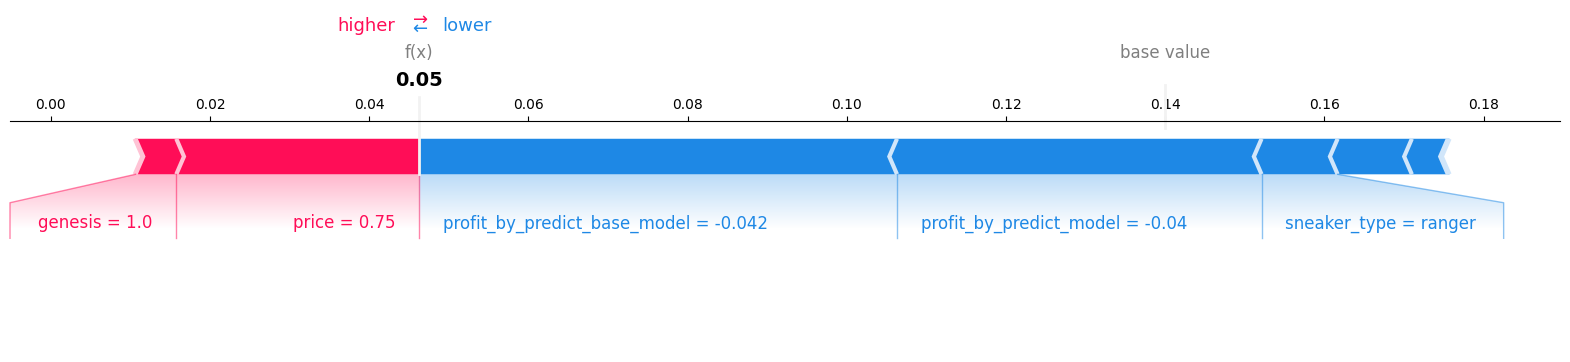

In [199]:
sample = pd.Series(sneaker_dict)
sample = pd.DataFrame(sample[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
#shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)